In [1]:
from ciw.dists import Exponential
from kmodes.kprototypes import KPrototypes
from scipy import special, stats
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from tqdm import tqdm
from yellowbrick.utils import KneeLocator

import ciw
import dask
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline
plt.style.use("default")
plt.style.use("seaborn-colorblind")

prop_cycle = plt.rcParams['axes.prop_cycle']
colours = prop_cycle.by_key()['color']


In [2]:
copd = pd.read_csv(
    "/Volumes/thesis-data/copd.csv", parse_dates=["admission_date", "discharge_date"]
)


In [3]:
for col in copd.columns:
    if copd[col].isnull().sum() > .25 * len(copd):
        copd = copd.drop(col, axis=1)

copd = copd[copd["true_los"] <= 365]
copd = copd.dropna()


In [26]:
clinicals = [
    "n_spells",
    "n_wards",
    "n_consultants",
    "true_los",
    "n_pr_attendances",
    "n_sn_attendances",
    "n_copd_admissions_last_year",
    "charlson_gross",
    "n_icds",
    "intervention",
    "day_of_week",
    "gender",
]

codes = [
    "infectious",
    "neoplasms",
    "blood",
    "endocrine",
    "mental",
    "nervous",
    "eye",
    "ear",
    "circulatory",
    "respiratory",
    "digestive",
    "skin",
    "muscoloskeletal",
    "genitourinary",
    "perinatal",
    "congenital",
    "abnormal_findings",
    "injury",
    "external_causes", 
    "contact_factors",
    "special_use",
]

conditions = [
    "ami",
    "cva",
    "chf",
    "ctd",
    "dementia",
    "diabetes",
    "liver_disease",
    "peptic_ulcer",
    "pvd",
    "pulmonary_disease",
    "cancer",
    "diabetic_complications",
    "paraplegia",
    "renal_disease",
    "metastatic_cancer",
    "sever_liver_disease",
    "hiv",
    "cdiff",
    "mrsa",
    "obese",
    "sepsis",
]

cols = clinicals + codes + conditions
data = copd[cols].copy()

categorical = [
    i
    for i, (col, dtype) in enumerate(dict(data.dtypes).items())
    if dtype == "object"
]


In [27]:
# APPROX. 40 minute runtime.

knee_results = []
cluster_range = range(2, 9)
for n_clusters in tqdm(cluster_range):

    kp = KPrototypes(n_clusters, init="cao", random_state=0, n_jobs=6)
    kp.fit(data, categorical=categorical)

    knee_results.append(kp.cost_)

100%|██████████| 7/7 [07:54<00:00, 73.71s/it]


In [29]:
kl = KneeLocator(
    cluster_range,
    knee_results,
    curve_nature="convex",
    curve_direction="decreasing",
)

n_clusters = kl.knee

with open("../data/n_clusters.txt", "w") as f:
    f.write(str(n_clusters))

knee_results = pd.Series(index=cluster_range, data=knee_results)
knee_results.to_csv("../data/knee_results.csv", header=False)

In [30]:
n_clusters

4

In [31]:
knee_results = pd.read_csv("../data/knee_results.csv", header=None).set_index(0)
with open("../data/n_clusters.txt", "r") as f:
    n_clusters = int(f.read())

Text(0, 0.5, 'Final cost')

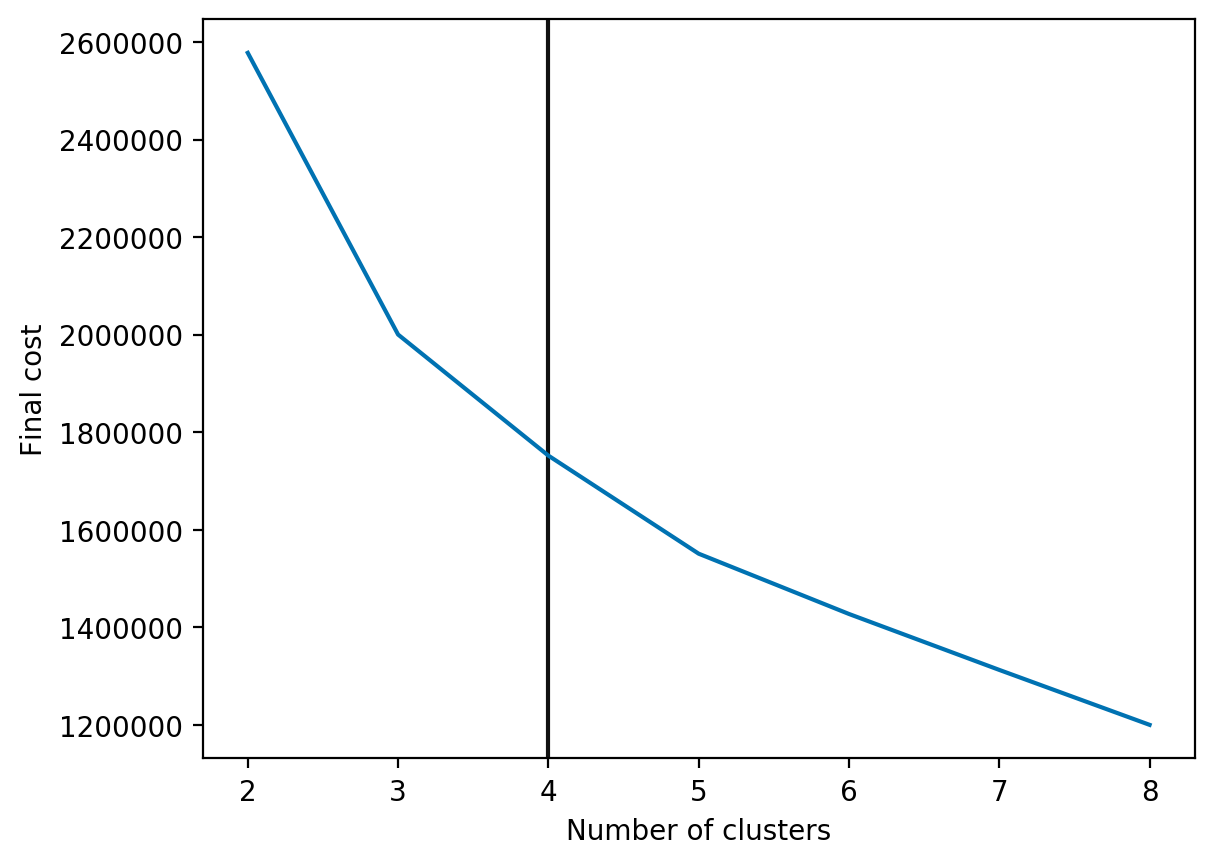

In [32]:
fig, ax = plt.subplots(dpi=200)

ax.plot(knee_results.index, knee_results.values)

ylims = ax.get_ylim()
ax.vlines(n_clusters, *ylims)
ax.set_ylim(*ylims)

ax.set_xlabel("Number of clusters")
ax.set_ylabel("Final cost")


In [33]:
kp = KPrototypes(n_clusters, init="matching", random_state=0, n_jobs=6, verbose=1)
kp.fit(data, categorical=categorical)

labels = kp.labels_
copd["cluster"] = labels
copd.to_csv("../data/copd_clustered.csv", index=False)

Best run was number 2


In [34]:
knee_results.loc[n_clusters, 1], kp.cost_

(1752021.7550920153, 1752021.7550920157)

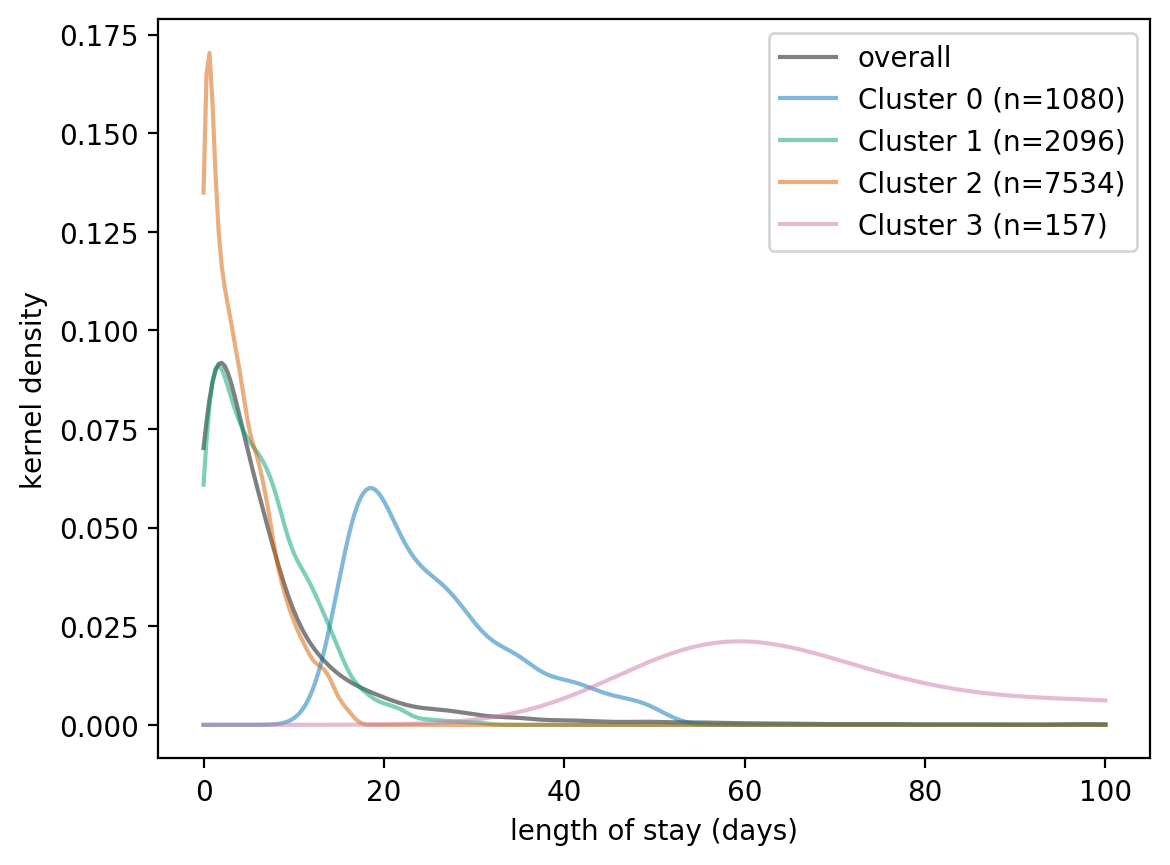

In [35]:
fig, ax = plt.subplots(dpi=200)

xs = np.linspace(0, 100, 300)
kernel = stats.gaussian_kde(copd["true_los"])
ax.plot(xs, kernel(xs), "gray", label="overall")

for cluster, times in copd.groupby("cluster")["true_los"]:

    colour = colours[cluster]
    kernel = stats.gaussian_kde(times)
    ax.plot(
        xs,
        kernel(xs),
        alpha=0.5,
        color=colour,
        label=f"Cluster {cluster} (n={len(times)})",
    )

ax.set_xlabel("length of stay (days)")
ax.set_ylabel("kernel density")

ax.legend()


In [36]:
def histograms(data, column, density=True, colours=colours):

    for cluster, values in copd.groupby("cluster")[column]:

        fig, ax = plt.subplots(dpi=100)

        ax.hist(
            copd[column],
            bins=9,
            facecolor="gray",
            alpha=0.2,
            density=True,
            label="overall",
        )

        colour = colours[cluster]
        ax.hist(values, alpha=0.5, facecolor=colour, density=True, label=cluster)

        ax.set_xlabel(" ".join(column.split("_")))
        ax.set_ylabel("frequency density")

        ax.legend()


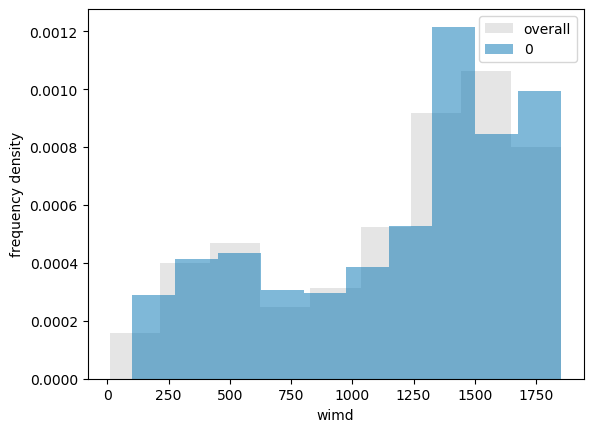

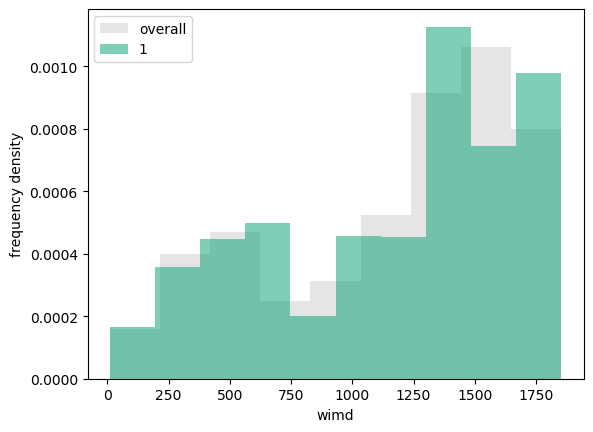

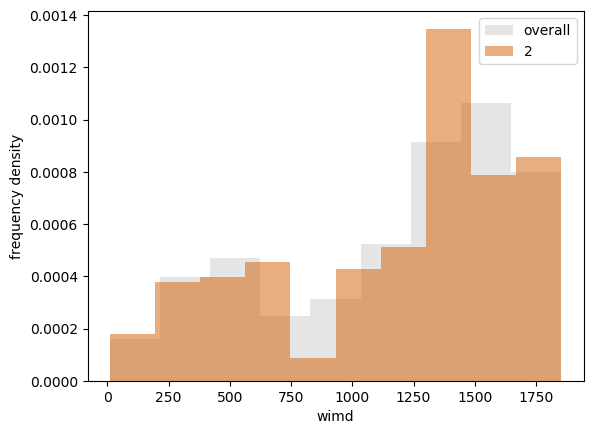

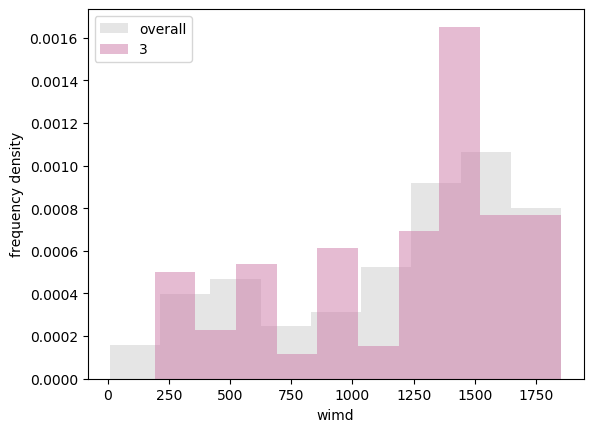

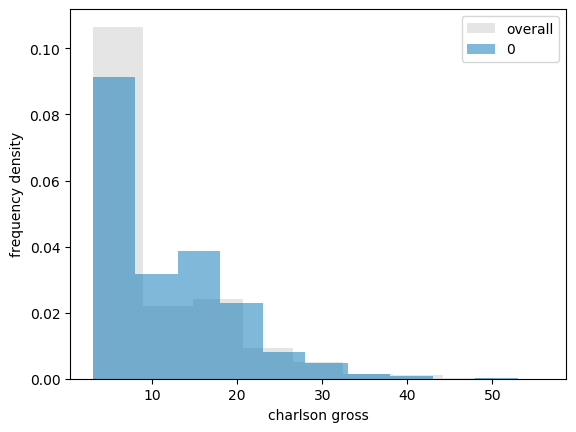

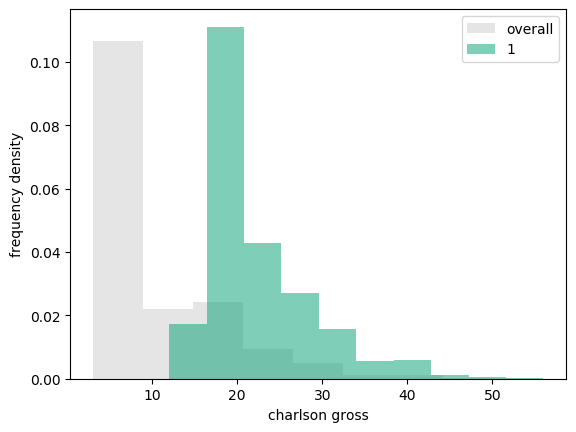

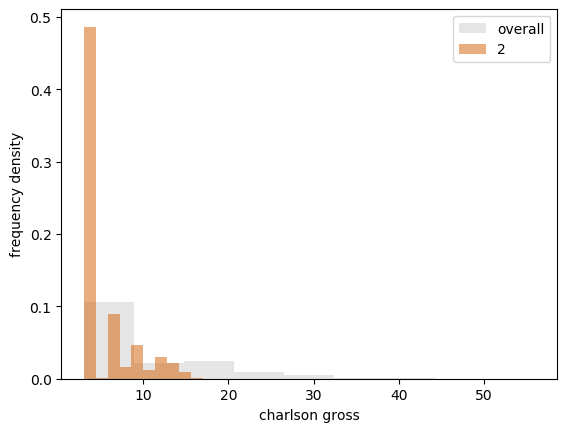

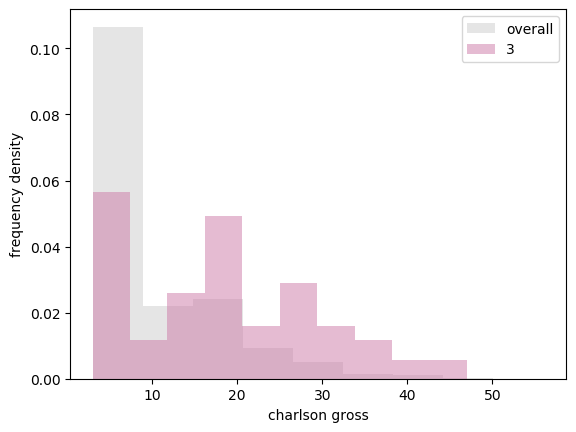

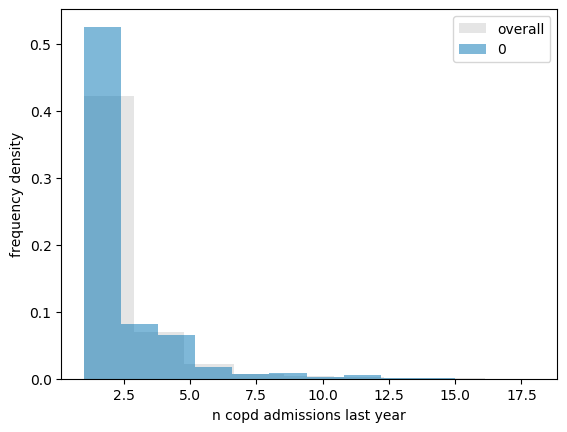

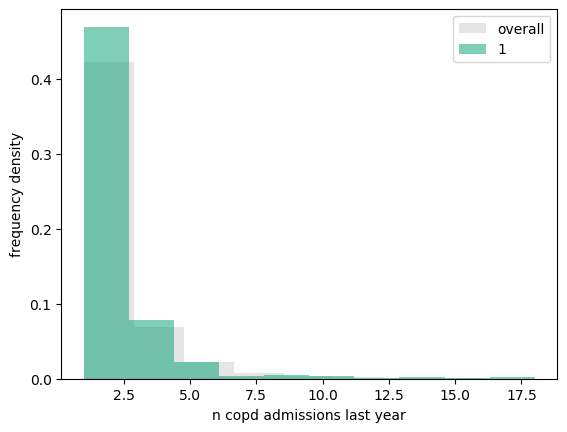

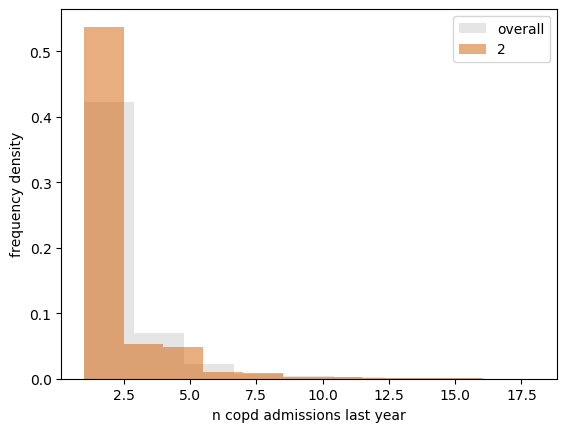

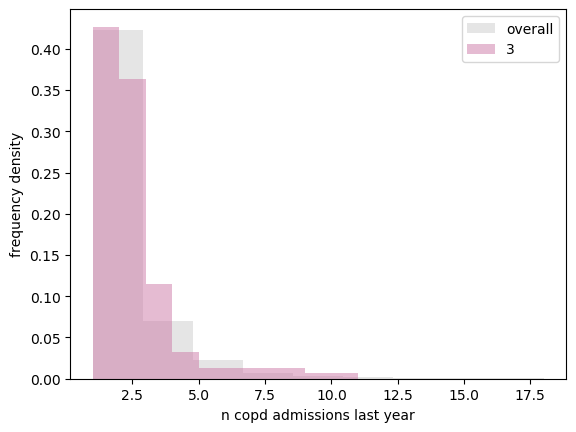

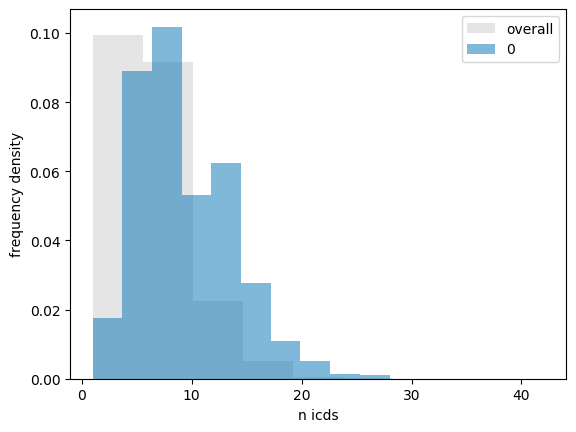

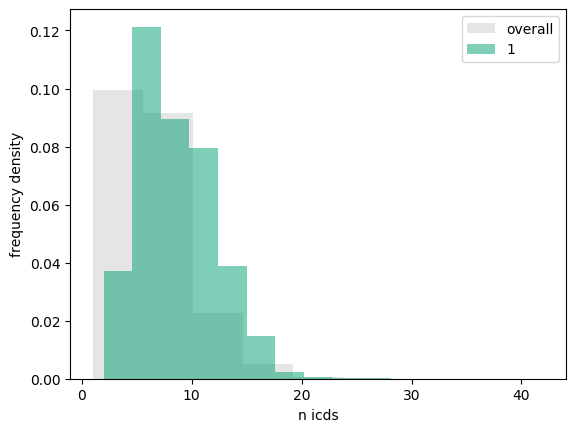

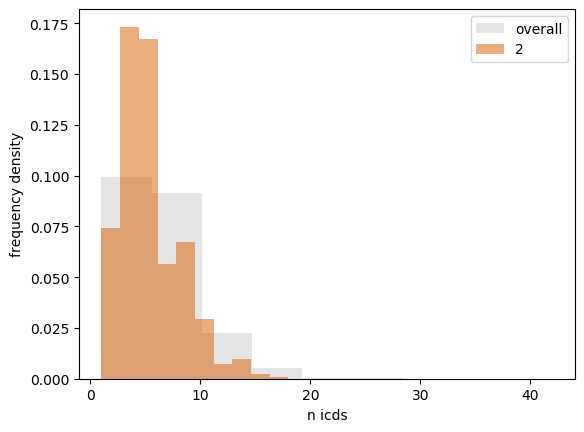

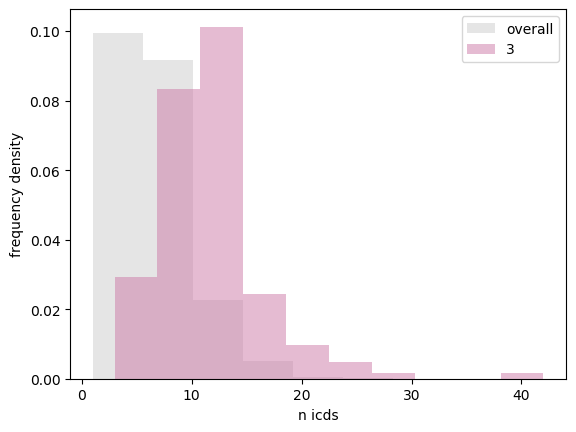

In [37]:
for col in [
    "wimd",
    "charlson_gross",
    "n_copd_admissions_last_year",
    "n_icds",
]:
    histograms(copd, col)


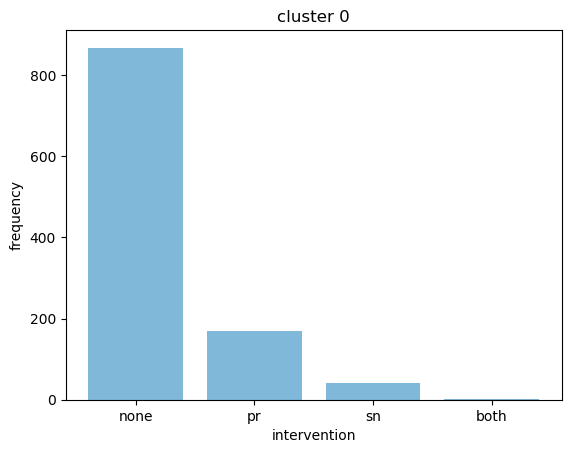

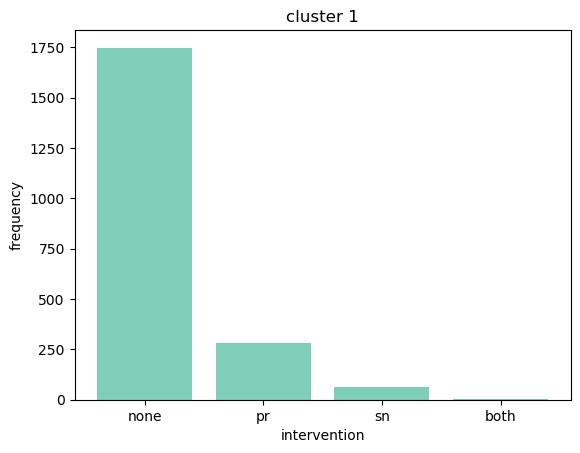

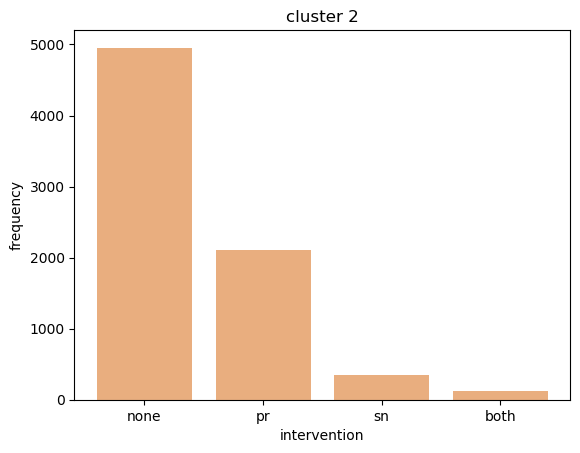

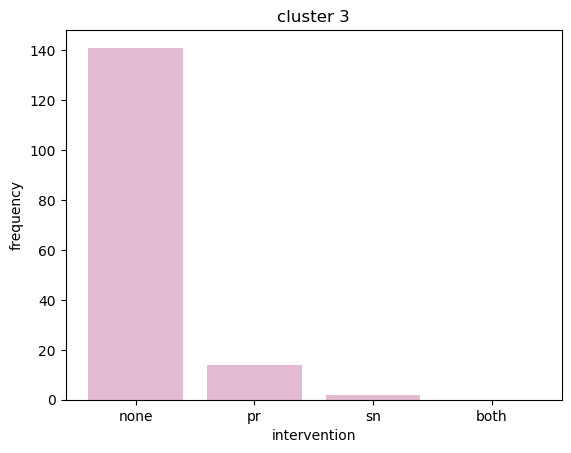

In [38]:
for cluster, values in copd.groupby("cluster")["intervention"]:

    fig, ax = plt.subplots(dpi=100)

    counts = values.value_counts().reindex(["none", "pr", "sn", "both"]).fillna(0)
    ax.bar(counts.index, counts.values, facecolor=colours[cluster], alpha=0.5)

    ax.set_xlabel("intervention")
    ax.set_ylabel("frequency")
    ax.set_title(f"cluster {cluster}")
